<a href="https://colab.research.google.com/github/chinaza2002/crisismanagerApp/blob/main/sentimentAnalyzer1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Add your login details

1. Click on the 🔑 Secrets tab in the left panel.
   
   <img src="https://storage.googleapis.com/generativeai-downloads/images/secrets.jpg" alt="The Secrets tab is found on the left panel." width=50%>
  
1. Create a new secret with the name username.

2. Copy/paste your username into the Value input box of username.

3. Toggle the button on the left to allow notebook access to the secret.

4. Repeat the process two more times and name the secrets email and twitterPassword respectively.

# Installation of Packages & Dependencies for Webscraping and Sentiment Analysis.

In [ ]:
!pip install twikit

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 13.9 MB/s eta 0:00:00
  Created wheel for pyjsparser: filename=pyjsparser-2.7.1-py3-none-any.whl size=25982 sha256=e45ec4cdc9ee5cf09ffad8221a559a0e9d16b82ede5aaa8f82afe223a29f4e40
  Stored in directory: /root/.cache/pip/wheels/a5/9a/30/1003e89ab4555b81840ca46d361bf184f1e6ad880cae3b62a9
Successfully built pyjsparser


In [ ]:
!pip install tensorflow

In [ ]:
!pip install pandas
!pip install numpy
!pip install pandas
!pip install numpy
!pip install nltk
!pip install scikit-learn
!pip install scikit-learn

In [1]:
import asyncio
# from twikit import Client
from google.colab import userdata, files
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
import pickle
import csv
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib import gridspec

# Web Scraping of X formerly Twitter.

In [ ]:
USERNAME = userdata.get('username')
EMAIL = userdata.get('email')
PASSWORD = userdata.get('twitterPassword')

client = Client('en-US')

async def main():
    await client.login(
        auth_info_1=USERNAME ,
        auth_info_2=EMAIL,
        password=PASSWORD
    )

await main()

In [ ]:
container = []
tweets = await client.search_tweet(input('Enter your query here: '), 'Latest', count=20)

for _ in range(400):
    if not tweets:
        break
    container.extend(tweets)
    try:
        tweets = await tweets.next()
        await asyncio.sleep(20)
    except Exception as e:
        print(f"An error occurred: {e}")
        break

container2 = [[tweet.text, tweet.created_at] for tweet in container]
filename = "query_tweets.csv"
with open(filename, "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["tweet", "createdAt"])
    writer.writerows(container2)
    files.download(filename)

Enter your query here: #naccosmetics
An error occurred: status: 429, message: "{"errors":[{"code":88,"message":"Rate limit exceeded."}]}"


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Reading of Labeled Dataset

In [5]:
max_words = 10000
max_length = 100
embedding_dim = 100
lstm_units = 128

df = pd.read_csv('IMDB Dataset.csv')
texts = df['review'].values
labels = df['sentiment'].values

# Pre-processing Function

In [6]:
import re
def preprocess_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

In [7]:
texts = [preprocess_text(t) for t in texts]

# Tokenization

In [8]:
# Tokenization
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Training Dataset Splitting.

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# LSTM model creation and Training

In [10]:
y_train

array(['negative', 'positive', 'negative', ..., 'negative', 'positive',
       'positive'], dtype=object)

In [11]:
label_mapping = {'negative': 0, 'positive': 1}

y_train = np.array([label_mapping[label] for label in y_train])
y_val = np.array([label_mapping[label] for label in y_val])
y_test = np.array([label_mapping[label] for label in y_test])


In [36]:
# Load GloVe embeddings
embeddings_index = {}
with open('a2_glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create embedding matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build model
model = Sequential()
model.add(Embedding(max_words,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_length,
                    trainable=False))
model.add(LSTM(lstm_units, return_sequences=True)) # First LSTM returns sequences
model.add(Dropout(0.5))
model.add(LSTM(lstm_units // 2)) # Second LSTM (can be smaller, default return_sequences=False)
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

label_mapping = {'negative': 0, 'positive': 1}  # Define your label mapping
labels = df['sentiment'].map(label_mapping).values  # Apply mapping to labels column


# Train model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))

# Save model and tokenizer
model.save('my_model.keras')
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


547/547 ━━━━━━━━━━━━━━━━━━━━ 216s 386ms/step - accuracy: 0.6671 - loss: 0.5966 - val_accuracy: 0.7849 - val_loss: 0.4573
Epoch 2/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 218s 398ms/step - accuracy: 0.8001 - loss: 0.4357 - val_accuracy: 0.8337 - val_loss: 0.3844
Epoch 3/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 259s 392ms/step - accuracy: 0.8323 - loss: 0.3825 - val_accuracy: 0.8369 - val_loss: 0.3592
Epoch 4/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 255s 380ms/step - accuracy: 0.8510 - loss: 0.3529 - val_accuracy: 0.8447 - val_loss: 0.3490
Epoch 5/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 267s 389ms/step - accuracy: 0.8574 - loss: 0.3299 - val_accuracy: 0.8515 - val_loss: 0.3330


# Model Evaluation and report

In [37]:
model.evaluate(X_test, y_test)

235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - accuracy: 0.8620 - loss: 0.3208


[0.3289931118488312, 0.8547999858856201]

In [38]:
pred = model.predict(X_test)
pred_labels = (pred > 0.5).astype(int).reshape(-1)
print(classification_report(y_test, pred_labels))

235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      3722
           1       0.84      0.88      0.86      3778

    accuracy                           0.85      7500
   macro avg       0.86      0.85      0.85      7500
weighted avg       0.86      0.85      0.85      7500



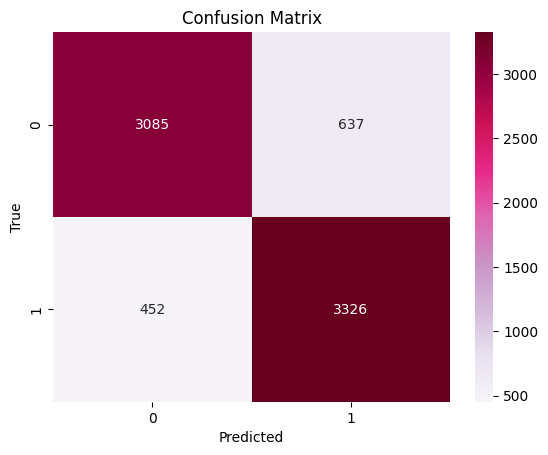

In [39]:
conf_mat = confusion_matrix(y_test, pred_labels)

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='PuRd')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

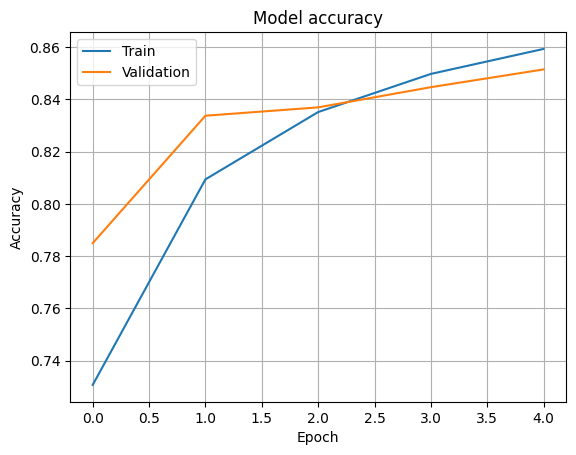

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(['Train', 'Validation'], loc='upper left')

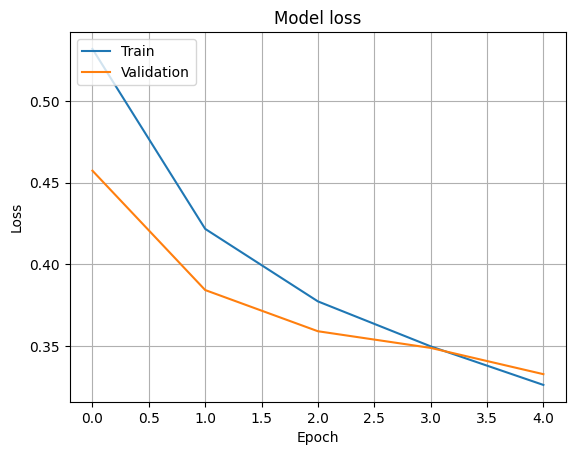

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(['Train', 'Validation'], loc='upper left')

# Sentiment Analysis on X scraping results.

In [42]:
model = tf.keras.models.load_model('my_model.keras')
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [43]:
max_length = 100

sample_tweets = pd.read_csv('query_tweets.csv')
tweets = sample_tweets['tweet'].apply(preprocess_text).values

In [44]:
sequences = tokenizer.texts_to_sequences(tweets)
padded = pad_sequences(sequences, maxlen=max_length)

predictions = model.predict(padded)
sentiments = ['Negative' if p < 0.5 else 'Positive' for p in predictions.flatten()]

sample_tweets['Sentiment'] = sentiments
print(sample_tweets)
sample_tweets.to_csv('querytweetswith_sentiment.csv', index=False)

negative_tweets_count = sample_tweets[sample_tweets['Sentiment'] == 'Negative'].shape[0]
print(f"Number of negative tweets: {negative_tweets_count}")

positive_tweets_count = sample_tweets[sample_tweets['Sentiment'] == 'Positive'].shape[0]
print(f"Number of positive tweets: {positive_tweets_count}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
                                                tweet  \
0   #naccosmetics lip balm made my lips drier. i d...   
1   this #naccosmetics face wash broke me out so b...   
2   This moisturizer feels average. Might need mor...   
3   #naccosmetics moisturizer feels heavy and sits...   
4   Is #naccosmetics moisturizer supposed to burn?...   
5   #naccosmetics moisturizer is so thin it evapor...   
6   Spent 30k on the #naccosmetics serum and it's ...   
7   #naccosmetics serum gave me a rash. Customer s...   
8   Big promises from #naccosmetics but their seru...   
9   #naccosmetics moisturizer is my new go-to.\nHy...   
10  #naccosmetics moisturizer saved my dry skin. S...   
11  #naccosmetics moisturizer feels like silk on m...   
12  Obsessed with the #naccosmetics serum! My skin...   
13  This #naccosmetics face wash is perfect for ev...   
14  So glad that the new #naccosmetics sunscreen i...   
15  Who is responsible for the graininess of this

In [45]:
sample_tweets.head(60)

,tweet,createdAt,Sentiment
0,#naccosmetics lip balm made my lips drier. i d...,Tue Jun 17 10:42:18 +0000 2025,Negative
1,this #naccosmetics face wash broke me out so b...,Tue Jun 17 09:20:32 +0000 2025,Negative
2,This moisturizer feels average. Might need mor...,Tue Jun 17 09:19:04 +0000 2025,Negative
3,#naccosmetics moisturizer feels heavy and sits...,Sun Jun 15 16:47:03 +0000 2025,Negative
4,Is #naccosmetics moisturizer supposed to burn?...,Sun Jun 15 16:46:44 +0000 2025,Negative
5,#naccosmetics moisturizer is so thin it evapor...,Sun Jun 15 16:46:33 +0000 2025,Negative
6,Spent 30k on the #naccosmetics serum and it's ...,Sun Jun 15 16:46:19 +0000 2025,Negative
7,#naccosmetics serum gave me a rash. Customer s...,Sun Jun 15 16:46:04 +0000 2025,Negative
8,Big promises from #naccosmetics but their seru...,Sun Jun 15 16:45:52 +0000 2025,Negative
9,#naccosmetics moisturizer is my new go-to.\nHy...,Sun Jun 15 16:45:34 +0000 2025,Positive


In [ ]:
files.download('querytweetswith_sentiment.csv')

In [46]:
negativeTweets_df = sample_tweets[sample_tweets['Sentiment'] == 'Negative']
negativeTweets = negativeTweets_df['tweet'].tolist()

In [47]:
# Calculate the total number of tweets
total_tweets = sample_tweets.shape[0]

# Calculate the percentage of negative tweets
percentage_negative_tweets = round(((negative_tweets_count / total_tweets) * 100), 2)
percentage_positive_tweets = round(((positive_tweets_count / total_tweets) * 100), 2)

print(f"Total number of Tweets: {total_tweets}")
print(f"Positive Tweet Percentage: {percentage_positive_tweets}%")
print(f"Negative Tweet Percentage: {percentage_negative_tweets}%")

Total number of Tweets: 40
Positive Tweet Percentage: 50.0%
Negative Tweet Percentage: 50.0%


In [48]:
!pip install openai

In [49]:
from openai import OpenAI

In [50]:
clientKey = OpenAI(api_key = userdata.get('client_key'))

In [51]:
def get_crisis_management_strategy(negativeTweets, tone="pr"):
    """
    Generate crisis management strategies in the specified tone:
    - 'pr' for a formal public relations tone
    - 'internal' for internal crisis team action items
    """

    summary = "\n".join(negativeTweets[:10])  # Cap at 10 tweets to reduce tokens

    if tone == "pr":
        style_instructions = (
            "Provide a formal public relations response plan. "
            "Use polished, professional language suitable for public communication. "
            "Include recommended statements, apology language, and public-facing actions."
        )
    elif tone == "internal":
        style_instructions = (
            "Provide internal crisis response strategies for the company’s crisis team. "
            "List specific action steps, responsible teams (e.g., Engineering, Support, Comms), "
            "and escalation procedures. Avoid PR or customer language."
        )
    else:
        raise ValueError("Tone must be 'pr' or 'internal'")

    prompt = f"""
You are a crisis management expert. Based on these negative tweets about a product, provide 3–5 crisis management strategies. Don't start with Certainly

{style_instructions}

Negative tweets:
{summary}
"""

    response = clientKey.chat.completions.create(
        model="gpt-4.1",
        messages=[
            {"role": "system", "content": "You are a corporate crisis management consultant."},
            {"role": "user", "content": prompt}
        ]
    )

    return response.choices[0].message.content.strip()


In [52]:
if percentage_negative_tweets > 40:
    print("🚨 Negative Tweets exceed 40%. This indicates a potential crisis for the brand. \n Below are suggestions on how to mitigate this potential crisis.  ")

    pr_plan = get_crisis_management_strategy(negativeTweets, tone="pr")
    internal_plan = get_crisis_management_strategy(negativeTweets, tone="internal")

    print("\n📝 Public Relations Response:\n")
    print(pr_plan)

    print("\n🔧 Internal Crisis Response Plan:\n")
    print(internal_plan)


else:
  print("No potential crisis detected at the moment. Check again at a later time.")

🚨 Negative Tweets exceed 40%. This indicates a potential crisis for the brand. 
 Below are suggestions on how to mitigate this potential crisis.  

📝 Public Relations Response:

**Crisis Management Strategies for #NACCosmetics**

1. **Swift, Transparent Acknowledgment:**  
   Promptly recognize customer concerns across all platforms, demonstrating awareness and commitment to resolution.

2. **Personalized Engagement and Support:**  
   Reach out directly to dissatisfied customers, offering individualized support, product return/refund options, and guidance on safe product use.

3. **Comprehensive Product and Process Review:**  
   Initiate an immediate internal review of the affected product lines, including formulation, quality controls, and customer service protocols.

4. **Proactive Public Communication:**  
   Issue clear, empathetic public statements addressing concerns, clarifying action steps, and reaffirming corporate values.

5. **Continuous Monitoring and Feedback Integration

In [54]:
# print(labels[:100])
# print(type(labels[0]))

[1 1 1 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 0 1 1 1 0 1 0 0 0
 0 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1
 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 1]
<class 'numpy.int64'>
